In [72]:
from skimage.segmentation import clear_border
from imutils import contours
import numpy as np
#import argparse
import imutils
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [73]:
def extract_digits_and_symbols(image, charCnts, minW=5, minH=15):
	# grab the internal Python iterator for the list of character
	# contours, then  initialize the character ROI and location
	# lists, respectively
	charIter = charCnts.__iter__()
	rois = []
	locs = []

	# keep looping over the character contours until we reach the end
	# of the list
	while True:
		try:
			# grab the next character contour from the list, compute
			# its bounding box, and initialize the ROI
			c = next(charIter)
			(cX, cY, cW, cH) = cv2.boundingRect(c)
			roi = None

			# check to see if the width and height are sufficiently
			# large, indicating that we have found a digit
			if cW >= minW and cH >= minH:
				# extract the ROI
				roi = image[cY:cY + cH, cX:cX + cW]
				rois.append(roi)
				locs.append((cX, cY, cX + cW, cY + cH))

			# otherwise, we are examining one of the special symbols
			else:
				# MICR symbols include three separate parts, so we
				# need to grab the next two parts from our iterator,
				# followed by initializing the bounding box
				# coordinates for the symbol
				parts = [c, next(charIter), next(charIter)]
				(sXA, sYA, sXB, sYB) = (np.inf, np.inf, -np.inf,
					-np.inf)

				# loop over the parts
				for p in parts:
					# compute the bounding box for the part, then
					# update our bookkeeping variables
					(pX, pY, pW, pH) = cv2.boundingRect(p)
					sXA = min(sXA, pX)
					sYA = min(sYA, pY)
					sXB = max(sXB, pX + pW)
					sYB = max(sYB, pY + pH)

				# extract the ROI
				roi = image[sYA:sYB, sXA:sXB]
				rois.append(roi)
				locs.append((sXA, sYA, sXB, sYB))

		# we have reached the end of the iterator; gracefully break
		# from the loop
		except StopIteration:
			break

	# return a tuple of the ROIs and locations
	return (rois, locs)

In [74]:
args = {'reference' :'images/micr_e13b_reference.png', 'image' : 'images/example_check.png'}

In [75]:
# initialize the list of reference character names, in the same
# order as they appear in the reference image where the digits
# their names and:
# T = Transit (delimit bank branch routing transit #)
# U = On-us (delimit customer account number)
# A = Amount (delimit transaction amount)
# D = Dash (delimit parts of numbers, such as routing or account)
charNames = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "0",
	"T", "U", "A", "D"]

In [76]:
# load the reference MICR image from disk, convert it to grayscale,
# and threshold it, such that the digits appear as *white* on a
# *black* background
ref = cv2.imread(args["reference"])
ref = cv2.cvtColor(ref, cv2.COLOR_BGR2GRAY)
ref = imutils.resize(ref, width=400)
ref = cv2.threshold(ref, 0, 255, cv2.THRESH_BINARY_INV |cv2.THRESH_OTSU)[1]

In [77]:
# find contours in the MICR image (i.e,. the outlines of the
# characters) and sort them from left to right
refCnts = cv2.findContours(ref.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
refCnts = refCnts[0] if imutils.is_cv2() else refCnts[1]
refCnts = contours.sort_contours(refCnts, method="left-to-right")[0]

In [78]:
# extract the digits and symbols from the list of contours, then
# initialize a dictionary to map the character name to the ROI
refROIs = extract_digits_and_symbols(ref, refCnts,
	minW=10, minH=20)[0]
chars = {}

In [79]:
# loop over the reference ROIs
for (name, roi) in zip(charNames, refROIs):
	# resize the ROI to a fixed size, then update the characters
	# dictionary, mapping the character name to the ROI
	roi = cv2.resize(roi, (36, 36)) 
	chars[name] = roi

In [80]:
# initialize a rectangular kernel (wider than it is tall) along with
# an empty list to store the output of the check OCR
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (17, 7))
output = []

In [81]:
# load the input image, grab its dimensions, and apply array slicing
# to keep only the bottom 20% of the image (that's where the account
# information is)
image = cv2.imread(args["image"])
(h, w,) = image.shape[:2]
delta = int(h - (h * 0.2))
bottom = image[delta:h, 0:w]

In [82]:
# convert the bottom image to grayscale, then apply a blackhat
# morphological operator to find dark regions against a light
# background (i.e., the routing and account numbers)
gray = cv2.cvtColor(bottom, cv2.COLOR_BGR2GRAY)
blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, rectKernel)

In [83]:
# compute the Scharr gradient of the blackhat image, then scale
# the rest back into the range [0, 255]
gradX = cv2.Sobel(blackhat, ddepth=cv2.CV_32F, dx=1, dy=0,
	ksize=-1)
gradX = np.absolute(gradX)
(minVal, maxVal) = (np.min(gradX), np.max(gradX))
gradX = (255 * ((gradX - minVal) / (maxVal - minVal)))
gradX = gradX.astype("uint8")

In [84]:
# apply a closing operation using the rectangular kernel to help
# cloes gaps in between rounting and account digits, then apply
# Otsu's thresholding method to binarize the image
gradX = cv2.morphologyEx(gradX, cv2.MORPH_CLOSE, rectKernel)
thresh = cv2.threshold(gradX, 0, 255,
	cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

In [85]:
# remove any pixels that are touching the borders of the image (this
# simply helps us in the next step when we prune contours)
thresh = clear_border(thresh)

In [86]:
# find contours in the thresholded image, then initialize the
# list of group locations
groupCnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
groupCnts = groupCnts[0] if imutils.is_cv2() else groupCnts[1]
groupLocs = []

In [87]:
# loop over the group contours
for (i, c) in enumerate(groupCnts):
	# compute the bounding box of the contour
	(x, y, w, h) = cv2.boundingRect(c)

	# only accept the contour region as a grouping of characters if
	# the ROI is sufficiently large
	if w > 50 and h > 15:
		groupLocs.append((x, y, w, h))

In [88]:
# sort the digit locations from left-to-right
groupLocs = sorted(groupLocs, key=lambda x:x[0])

In [89]:
# loop over the group locations
for (gX, gY, gW, gH) in groupLocs:
	# initialize the group output of characters
	groupOutput = []
	# extract the group ROI of characters from the grayscale
	# image, then apply thresholding to segment the digits from
	# the background of the credit card
	group = gray[gY - 5:gY + gH + 5, gX - 5:gX + gW + 5]
	group = cv2.threshold(group, 0, 255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    # find character contours in the group, then sort them from
	# left to right
	charCnts = cv2.findContours(group.copy(), cv2.RETR_EXTERNAL,
		cv2.CHAIN_APPROX_SIMPLE)
	charCnts = charCnts[0] if imutils.is_cv2() else charCnts[1]
	charCnts = contours.sort_contours(charCnts,
		method="left-to-right")[0]

	# find the characters and symbols in the group
	(rois, locs) = extract_digits_and_symbols(group, charCnts)

	# loop over the ROIs from the group
	for roi in rois:
		# initialize the list of template matching scores and
		# resize the ROI to a fixed size
		scores = []
		roi = cv2.resize(roi, (36, 36))

		# loop over the reference character name and corresponding
		# ROI
		for charName in charNames:
			# apply correlation-based template matching, take the
			# score, and update the scores list
			result = cv2.matchTemplate(roi, chars[charName],
				cv2.TM_CCOEFF)
			(_, score, _, _) = cv2.minMaxLoc(result)
			scores.append(score)

		# the classification for the character ROI will be the
		# reference character name with the *largest* template
		# matching score
		groupOutput.append(charNames[np.argmax(scores)])

	# draw (padded) bounding box surrounding the group along with
	# the OCR output of the group
	cv2.rectangle(image, (gX - 10, gY + delta - 10),
		(gX + gW + 10, gY + gY + delta), (0, 0, 255), 2)
	cv2.putText(image, "".join(groupOutput),
		(gX - 10, gY + delta - 25), cv2.FONT_HERSHEY_SIMPLEX,
		0.95, (0, 0, 255), 3)

	# add the group output to the overall check OCR output
	output.append("".join(groupOutput))

In [90]:
print("Check OCR: {}".format(" ".join(output)))

Check OCR: T011300142T 12345678U 0101


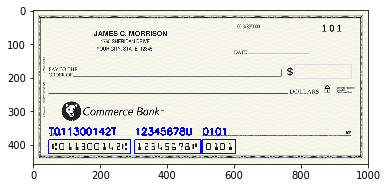

In [91]:
plt.imshow(image)